# Oridnary Kriging using scikit-gstat package - Meuse Dataset

https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/skgstat/Variogram.py#L1312
    
    
https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/tutorials/01_getting_started.ipynb

https://scikit-gstat.readthedocs.io/en/latest/userguide/kriging.html#spatial-interpolation


In [54]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
import skgstat as skg
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [8]:
meuse_df = pd.read_csv("meuse_processed.csv")

In [9]:
display(meuse_df)

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,cluster_num
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50,0
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30,0
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150,0
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270,0
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540,7
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520,7
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350,1
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460,7


## Splitting Data

In [10]:
# Convert columns to numpy arrays
observed_location_columns_meuse = ['x', 'y','cluster_num']
observed_values_column_meuse = 'zinc'
observed_locations_meuse = meuse_df[observed_location_columns_meuse].values
observed_values_meuse = meuse_df[observed_values_column_meuse].values

In [11]:
X_train_meuse, X_test_meuse, y_train_meuse, y_test_meuse = train_test_split(observed_locations_meuse,
                                                                            observed_values_meuse, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_meuse.shape}")
print(f"X_test_meuse.shape:  {X_test_meuse.shape}")
print(f"y_train_meuse.shape: {y_train_meuse.shape}")
print(f"y_test_meuse.shape:  {y_test_meuse.shape}")

X_train_meuse.shape: (124, 3)
X_test_meuse.shape:  (31, 3)
y_train_meuse.shape: (124,)
y_test_meuse.shape:  (31,)


## Understanding distribution of clusters in train and test sets

In [12]:
x_values = [element[0] for element in X_train_meuse]
y_values = [element[1] for element in X_train_meuse]
cluster_values = [element[2] for element in X_train_meuse]

data = {
    'x': x_values,
    'y': y_values,
    'cluster_num': cluster_values
}

train_df = pd.DataFrame(data)
train_df['cluster_num'] = train_df['cluster_num'].astype('category')

x_values_test = [element[0] for element in X_test_meuse]
y_values_test = [element[1] for element in X_test_meuse]
cluster_values_test = [element[2] for element in X_test_meuse]

data_test  = {
    'x': x_values_test,
    'y': y_values_test,
    'cluster_num': cluster_values_test
}

test_df = pd.DataFrame(data_test)
test_df['cluster_num'] = test_df['cluster_num'].astype('category')

In [13]:
train_df.describe(include='all')

,x,y,cluster_num
count,124.000000,124.000000,124.0
unique,NaN,NaN,8.0
top,NaN,NaN,0.0
freq,NaN,NaN,19.0
mean,180033.290323,331681.548387,NaN
std,744.898103,1048.719020,NaN
min,178605.000000,329714.000000,NaN
25%,179437.250000,330792.500000,NaN
50%,180083.500000,331697.000000,NaN
75%,180655.000000,332509.250000,NaN


<Axes: >

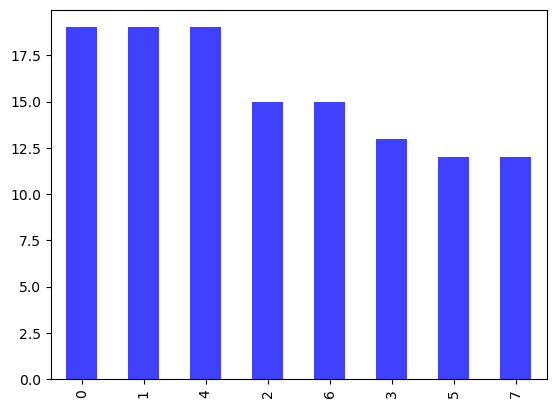

In [14]:
# Count the occurrences of each category
category_counts = train_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue')

In [15]:
test_df.describe(include='all')

,x,y,cluster_num
count,31.000000,31.000000,31.0
unique,NaN,NaN,8.0
top,NaN,NaN,1.0
freq,NaN,NaN,9.0
mean,179889.838710,331448.483871,NaN
std,751.728191,1039.762148,NaN
min,178803.000000,329733.000000,NaN
25%,179150.000000,330572.500000,NaN
50%,179792.000000,331150.000000,NaN
75%,180486.000000,332314.500000,NaN


<Axes: >

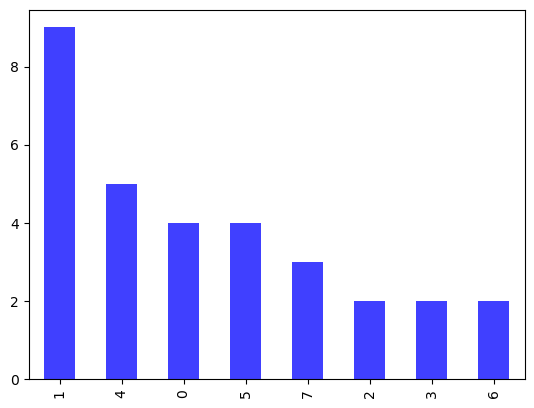

In [16]:
# Count the occurrences of each category
category_counts = test_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue')

## Spatial K-Fold Cross Validation

### Examining fit between theoratical and experimental variogram using RMSE

Before we proceed with cross validation, in Kriging, we can use the variogram as an indicator in determining if our model will perform well. This is done by analysing the fit between the theoratical variogram and experimental variogram. As without a good fit, the semi-variance value used for interpolation later on would not be optimal as well.

There are 6 different theoratical variogram models we can choose from, and here we can do a visual inspection of whether each of these theoratical model fits the experimental variogram, as well as calculate the RMSE as a numerical comparison across the different theoratical models. 

We can see that all 6 models is able to describe the experimental variogram more or less equally well in terms of RMSE, since the differences in the values are rather insignificant. However, this arises a problem, whereby some of these models actually describe fundamentally different spatial properties but yet the RMSE values are almost the same. Hence, using these indicators to decide which theoratical model would have the best fit would not be sufficent and cross validation should be done, where we fit the variogram with a different model and then consider the interpolated values.

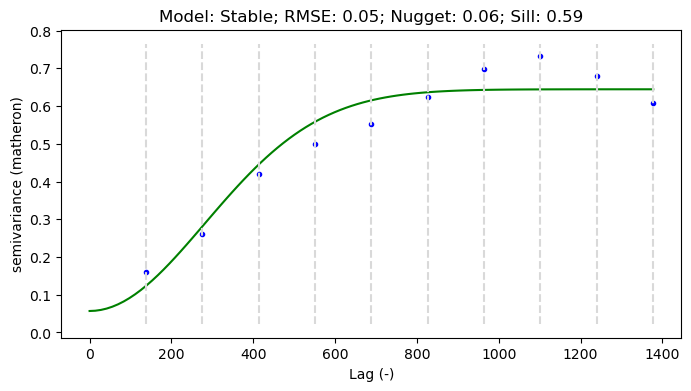

In [45]:
V = skg.Variogram(X_train_meuse, y_train_meuse,model = 'stable', fit_method = 'ml', use_nugget = True, maxlag = 'median')
# Plotting without the histogram and not showing it immediately
V.plot(hist=False, show=False)

plt.title(f'Model: Stable; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show()
                                                   
#print('Variogram sill: %.2f Nugget: %.2f' % (V.describe()['sill'], V.describe()['nugget']))

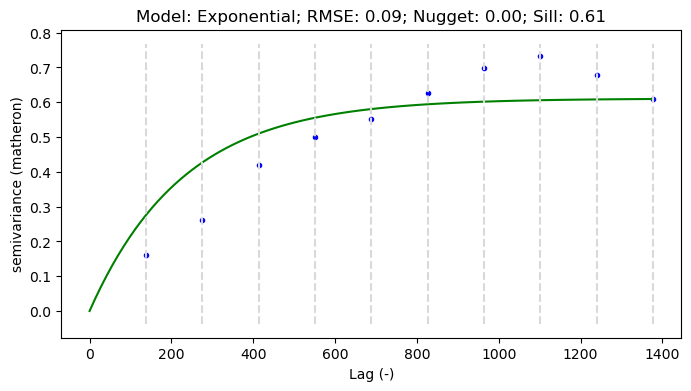

In [46]:
V = skg.Variogram(X_train_meuse, y_train_meuse,model = 'exponential', fit_method = 'ml', use_nugget = True, maxlag = 'median')
# Plotting without the histogram and not showing it immediately
V.plot(hist=False, show=False)

plt.title(f'Model: Exponential; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show()      

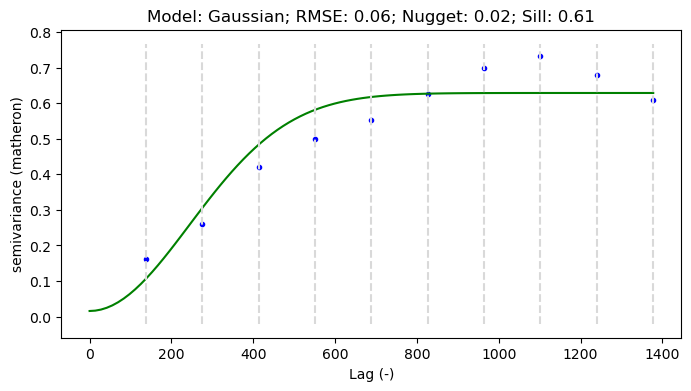

In [47]:
V = skg.Variogram(X_train_meuse, y_train_meuse,model = 'gaussian', fit_method = 'ml', use_nugget = True, maxlag = 'median')
# Plotting without the histogram and not showing it immediately
V.plot(hist=False, show=False)

plt.title(f'Model: Gaussian; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show() 

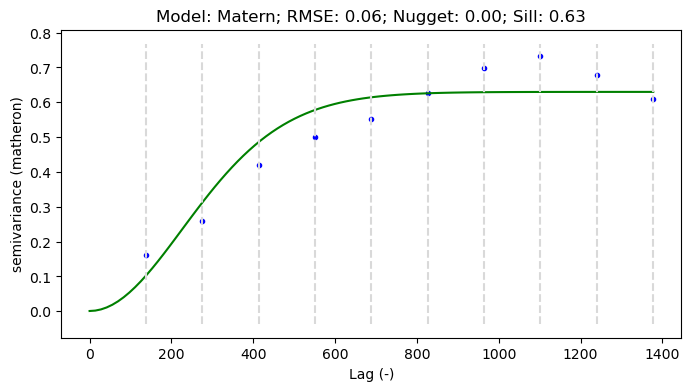

In [48]:
V = skg.Variogram(X_train_meuse, y_train_meuse,model = 'matern', fit_method = 'ml', use_nugget = True, maxlag = 'median')
# Plotting without the histogram and not showing it immediately
V.plot(hist=False, show=False)

plt.title(f'Model: Matern; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show() 

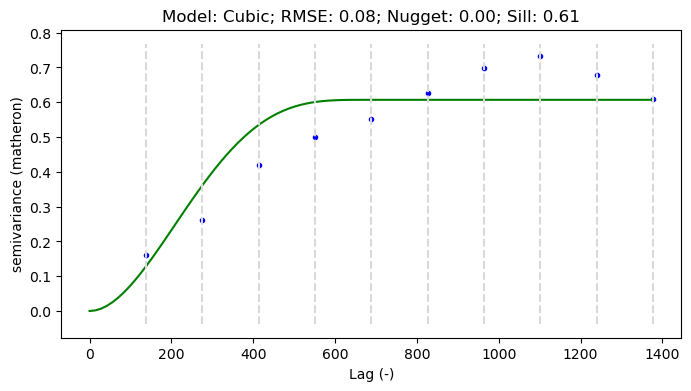

In [49]:
V = skg.Variogram(X_train_meuse, y_train_meuse,model = 'cubic', fit_method = 'ml', use_nugget = True, maxlag = 'median')
# Plotting without the histogram and not showing it immediately
V.plot(hist=False, show=False)

plt.title(f'Model: Cubic; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show() 

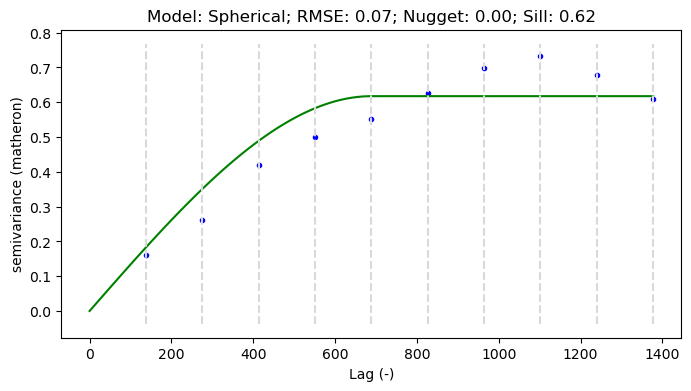

In [50]:
V = skg.Variogram(X_train_meuse, y_train_meuse,model = 'spherical', fit_method = 'ml', use_nugget = True, maxlag = 'median')
# Plotting without the histogram and not showing it immediately
V.plot(hist=False, show=False)

plt.title(f'Model: Spherical; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show() 

### Spatial K-Fold Cross Validation

Here, we will be doing K-Fold Cross validation, whereby for each of the 6 theoratical model, the training data is split into K Folds. We will fit the variogram on K-1 Folds, and then interpolate with the remaining fold. A cross valdiation score for this split will be calculated based on the actual values and the interpolated values, and we will repeat this for K times. 

Afterwards, we will get the mean cross validation score, which is the mean of the cross vbalidation scores obtained in each split. We will compute the score with 3 different metrics, namely: RMSE, Mean Absolute Error, Mean Absolute Percentage Error to conduct a more comprehensive analysis. 

In [55]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]
cluster_num_data_train = [inner_list[2] for inner_list in X_train_meuse]

In [116]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train, 
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

#For each possible theoratical model, conduct K-Fold CV
for model in models_list:
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 8)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []
    cv_scores_sigma = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        # Fit Variogram
        combined_array = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        V_train = skg.Variogram(combined_array, train_data['Z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)

        # Fit Ordinary Kriging model
        OK = skg.OrdinaryKriging(V_train, mode='exact')

        # Predict/Interpolate at test locations
        z_pred_train = OK.transform(test_data['X'], test_data['Y'])
        
        # Error handling as model returns NaN for points where predictions are not possible
        valid_idx = ~np.isnan(z_pred_train)
        y_true_clean = test_data['Z'][valid_idx]
        y_pred_clean = z_pred_train[valid_idx]
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
        r2 = r2_score(y_true_clean, y_pred_clean)
        sigma = np.mean(OK.sigma[valid_idx])
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        cv_scores_sigma.append(sigma)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    mean_validation_score_sigma = np.mean(cv_scores_sigma)
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[model] = {
        "Mean CV Score MAE" : mean_validation_score_mae,
        "Mean CV Score MAE" : mean_validation_score_rmse,
        "Mean CV Score MAPE" : mean_validation_score_mape,
        "Mean CV Score R Squared" : mean_validation_score_r2,
        "Mean CV Score Kriging Var" : mean_validation_score_sigma
    }

end_time = time.time()
# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric or the largest for R Squared
# Initialize a dictionary to track the scores and corresponding models
# For R Squared, we start with negative infinity to look for the maximum
smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "model": None},
    "Mean CV Score MAE": {"value": float('inf'), "model": None},
    "Mean CV Score MAPE": {"value": float('inf'), "model": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "model": None},  # Changed to '-inf' for maximization
    "Mean CV Score Kriging Var": {"value": float('inf'), "model": None}
}

# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")
        
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

,spherical,exponential,gaussian,matern,stable,cubic
Mean CV Score MAE,0.536332,0.542224,0.944950,0.989942,0.604192,0.728108
Mean CV Score MAPE,0.069816,0.074780,0.129349,0.136489,0.078233,0.094583
Mean CV Score R Squared,0.152020,0.104968,-1.902479,-3.285956,-0.131251,-0.745261
Mean CV Score Kriging Var,0.552985,0.591682,0.435881,0.444175,0.450781,0.498437


The smallest Mean CV Score MAE is 0.5363320481924106, found in model spherical.
The smallest Mean CV Score MAPE is 0.06981615859990842, found in model spherical.
The largest Mean CV Score R Squared is 0.1520197476597869, found in model spherical.
The smallest Mean CV Score Kriging Var is 0.435881479591573, found in model gaussian.


## Evaluation of Model (Testing Chosen model)

### Performance Metrics of Model

In [117]:
# Dataframe manipulation to fit Variogram paramaters
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]
data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
})
combined_array = np.array([list(pair) for pair in zip(data['X'], data['Y'])])

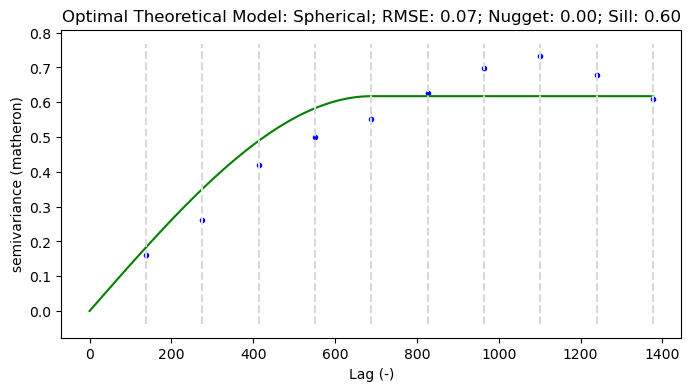

In [118]:
V_test = skg.Variogram(combined_array, y_train_meuse,maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_test.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Optimal Theoretical Model: Spherical; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

In [119]:
# Using list comprehension
x_data_test = [inner_list[0] for inner_list in X_test_meuse]
y_data_test = [inner_list[1] for inner_list in X_test_meuse]

data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_meuse
})
start_time = time.time()
# Fit Ordinary Kriging model
OK = skg.OrdinaryKriging(V_test, mode='exact')

# Predict at test locations
z_pred_test = OK.transform(data['X'], data['Y'])
        
# Calculate Metrics and append the validation score for each split into cv_scores_metric
rmse = np.sqrt(mean_squared_error(data['Z'], z_pred_test))
mae = mean_absolute_error(data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(data['Z'], z_pred_test)
r2 = r2_score(data['Z'], z_pred_test)
sigma = np.mean(OK.sigma)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print("Mean of Kriging Var:", sigma)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.23639878246425805
RMSE: 0.3222267276164075
MAPE: 0.04189670164563101
R Squared: 0.7621014406606756
Mean of Kriging Var: 0.16928194629420046


### Plotting Spatial Interpolation of entire area with Model

In [120]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

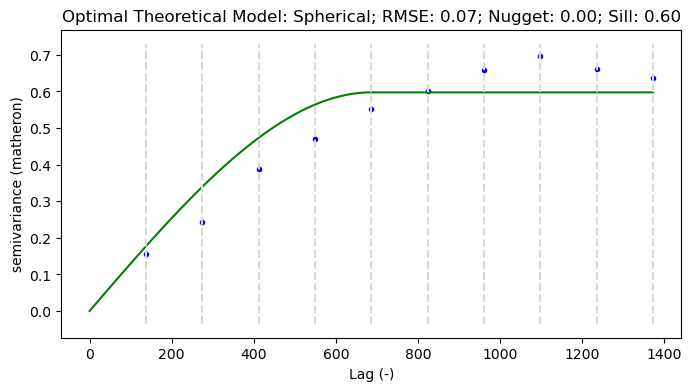

Sample variance: 0.52   Variogram sill: 0.60


In [121]:
V = skg.Variogram(observed_locations, observed_values,model = 'spherical',maxlag='median', use_nugget = True, fit_method = 'ml')
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Optimal Theoretical Model: Spherical; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')

plt.show()

print('Sample variance: %.2f   Variogram sill: %.2f' % (observed_values.flatten().var(), V.describe()['sill']))

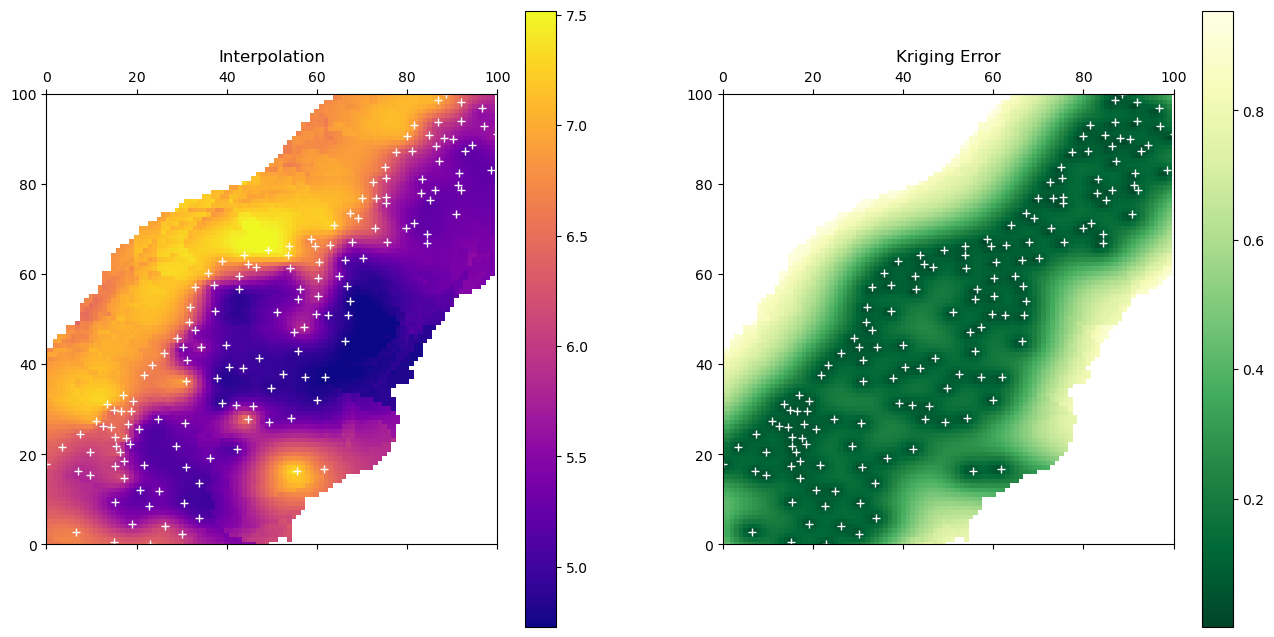

In [123]:
start_time_interpolation = time.time()
ok = skg.OrdinaryKriging(V, mode='exact')
# build the target grid
x = observed_locations[:,0]
y = observed_locations[:,1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=observed_values.min(), vmax=observed_values.max())
axes[0].set_title('Interpolation')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

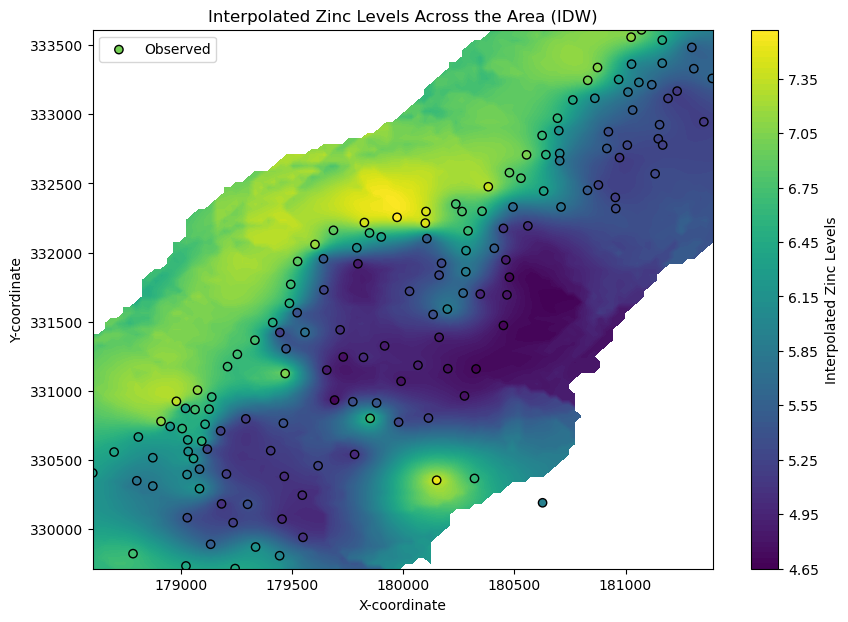

Spatial Interpolation Computation Time: 1.44 seconds


In [126]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = ok.transform(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

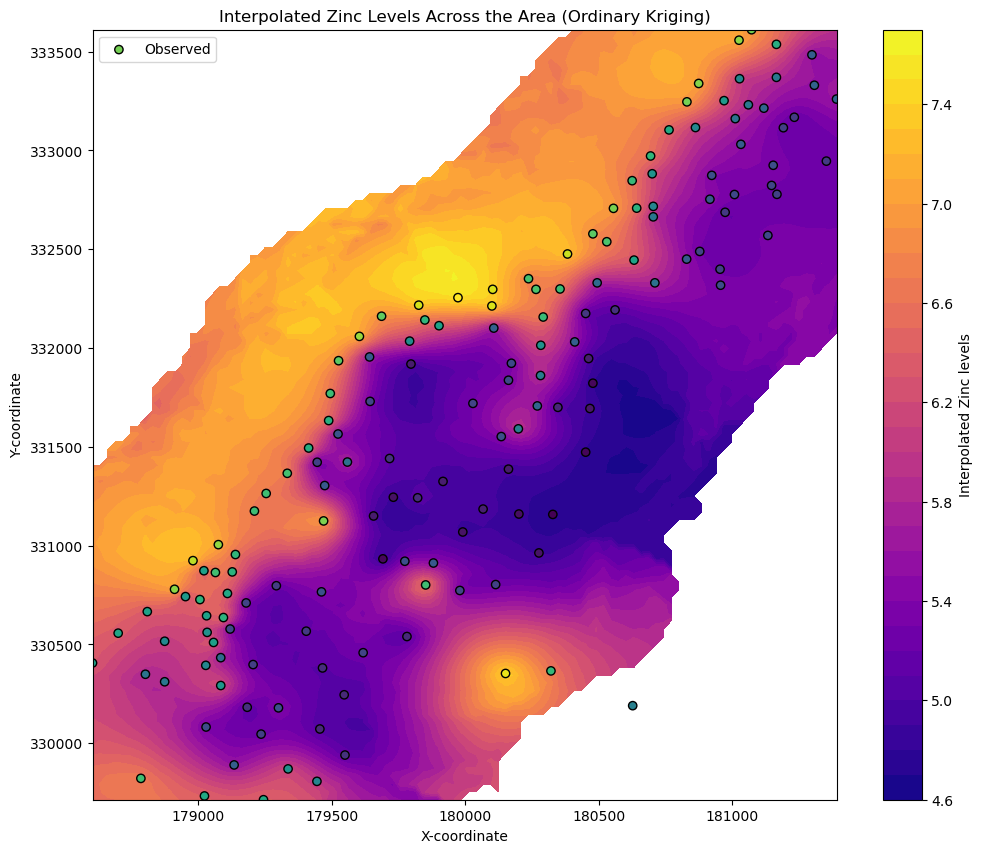

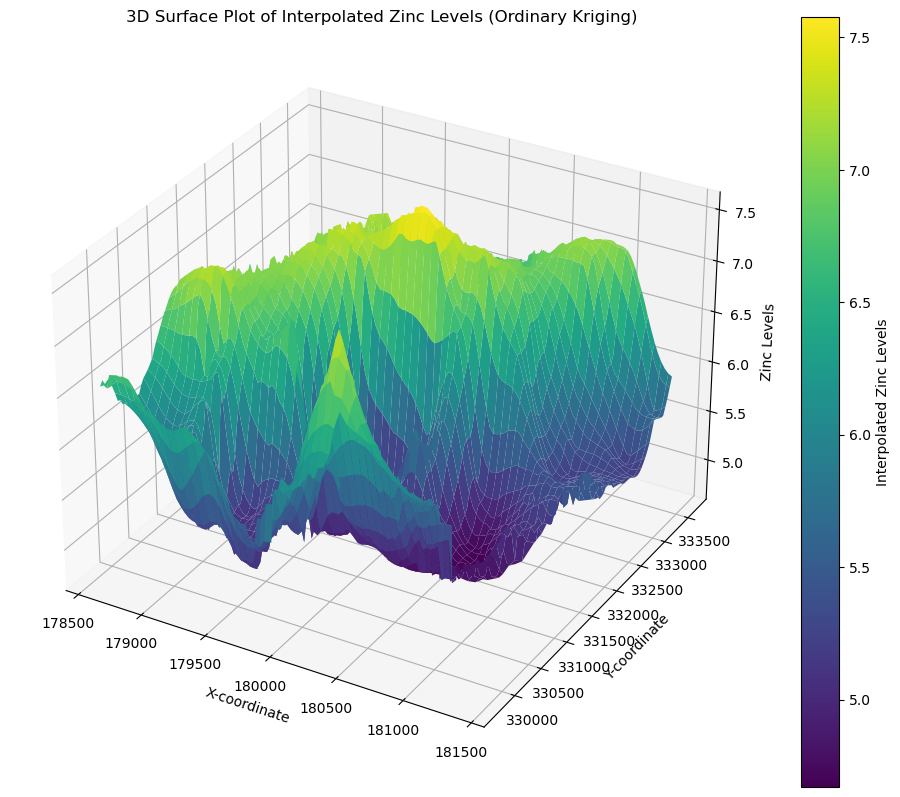

Spatial Interpolation Computation Time: 1.36 seconds


In [127]:
# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
y_min, y_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

start_time_interpolation = time.time()
# Interpolate values
interpolated_values = ok.transform(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()

fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated Zinc levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (Ordinary Kriging)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated Zinc Levels')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Zinc Levels')
ax.set_title('3D Surface Plot of Interpolated Zinc Levels (Ordinary Kriging)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

# Extra Code

In [69]:
def view_predicted(x_data, y_data, z_data, z_pred):
    
    observed_location_columns = ['x', 'y']
    observed_values_column = 'zinc'
    observed_locations = X_train_meuse
    observed_values = y_train_meuse

    x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
    y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
    x_range = np.linspace(x_min, x_max, 25)
    y_range = np.linspace(y_min, y_max, 25)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]


    z_grid = z_pred.reshape(x_grid.shape)


    # Visualization
    plt.figure(figsize=(10, 7))
    plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
    plt.colorbar(label='Interpolated Zinc Levels')
    plt.scatter(x_data, y_data, c = z_data, cmap='viridis', edgecolor='k', label='Observed')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.title('Interpolated Zinc Levels Across the Area')
    plt.show()


In [64]:
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values
print(observed_locations)

[[181072 333611]
 [181025 333558]
 [181165 333537]
 [181298 333484]
 [181307 333330]
 [181390 333260]
 [181165 333370]
 [181027 333363]
 [181060 333231]
 [181232 333168]
 [181191 333115]
 [181032 333031]
 [180874 333339]
 [180969 333252]
 [181011 333161]
 [180830 333246]
 [180763 333104]
 [180694 332972]
 [180625 332847]
 [180555 332707]
 [180642 332708]
 [180704 332717]
 [180704 332664]
 [181153 332925]
 [181147 332823]
 [181167 332778]
 [181008 332777]
 [180973 332687]
 [180916 332753]
 [181352 332946]
 [181133 332570]
 [180878 332489]
 [180829 332450]
 [180954 332399]
 [180956 332318]
 [180710 332330]
 [180632 332445]
 [180530 332538]
 [180478 332578]
 [180383 332476]
 [180494 332330]
 [180561 332193]
 [180451 332175]
 [180410 332031]
 [180355 332299]
 [180292 332157]
 [180283 332014]
 [180282 331861]
 [180270 331707]
 [180199 331591]
 [180135 331552]
 [180237 332351]
 [180103 332297]
 [179973 332255]
 [179826 332217]
 [179687 332161]
 [179792 332035]
 [179902 332113]
 [180100 33221

In [66]:
X_train_meuse.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

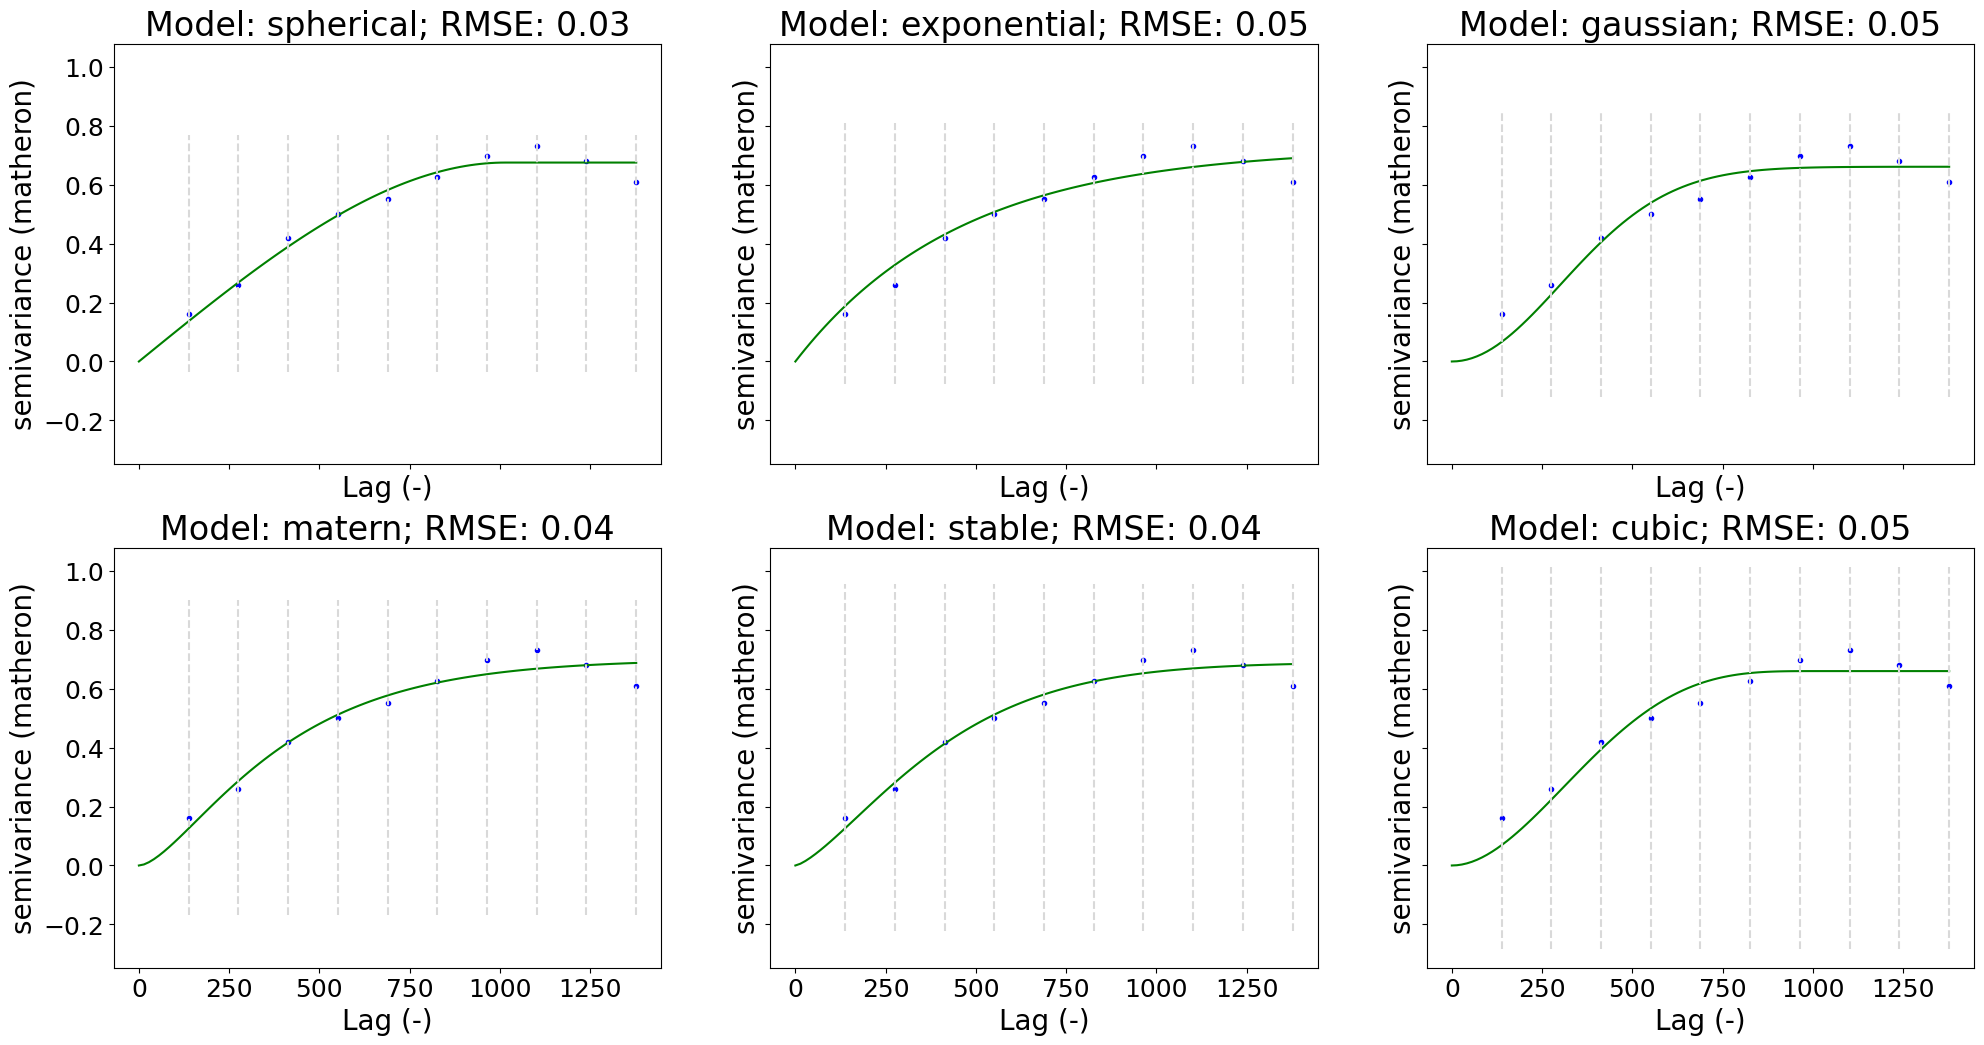

In [43]:
data = pd.DataFrame({
    'X': x_data,
    'Y': y_data,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

#Instantiate the variogram with the train data
V = skg.Variogram(X_train_meuse, y_train_meuse,maxlag='median', normalize=False)
fig, _a = plt.subplots(2,3, figsize=(24, 12), sharex=True, sharey=True)
axes = _a.flatten()

#For each possible theoratical model, conduct K-Fold CV
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V.rmse))

    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize a list to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Fit Ordinary Kriging model
        OK = skg.OrdinaryKriging(V, min_points=2, max_points=15, mode='exact')

        # Predict at test locations
        z_pred = OK.transform(test_data['X'], test_data['Y'])
        
        # Calculate RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred))
        mae = mean_absolute_error(test_data['Z'], z_pred)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        
        
    cv_score_list[model] = {
        'cv_scores_mae': cv_scores_mae,
        'cv_scores_rmse': cv_scores_rmse,
        'cv_scores_mape': cv_scores_mape
    }

In [44]:
cv = pd.DataFrame(cv_score_list)
display(cv)

,spherical,exponential,gaussian,matern,stable,cubic
cv_scores_mae,"[3.801403636316536e-15, 5.577760475716787e-15,...","[2.2026824808563106e-15, 3.623767952376511e-15...","[2.7133850721838826e-12, 2.0471802031352127e-1...","[5.4711790653527716e-15, 1.0835776720341527e-1...","[5.897504706808831e-15, 6.359357485052897e-15,...","[5.74473801862041e-14, 1.1375789199519205e-13,..."
cv_scores_rmse,"[4.8419981519170856e-15, 6.696182035515635e-15...","[2.6347629809804343e-15, 4.591117879940073e-15...","[5.795233262078774e-12, 3.5980845942612275e-12...","[7.254846628037419e-15, 1.494780795952368e-14,...","[7.828072247850565e-15, 1.0298274617522725e-14...","[7.834539224344886e-14, 1.8828393744762325e-13..."
cv_scores_mape,"[6.463912365815615e-16, 9.23414935641995e-16, ...","[3.7135122387856553e-16, 6.017329552366883e-16...","[4.1742495747136725e-13, 3.2751587977278664e-1...","[9.06670427322597e-16, 1.7809577131457344e-15,...","[9.954594254999007e-16, 1.067064659936926e-15,...","[9.403473164766107e-15, 1.779398413957242e-14,..."


Sample variance: 0.53   Variogram sill: 0.62
[nan nan]
Sample variance: 0.53   Variogram sill: 0.62
[nan nan]
Sample variance: 0.53   Variogram sill: 0.64
[nan nan]
Sample variance: 0.53   Variogram sill: 0.61
[nan nan]
Sample variance: 0.53   Variogram sill: 0.65
[nan nan]


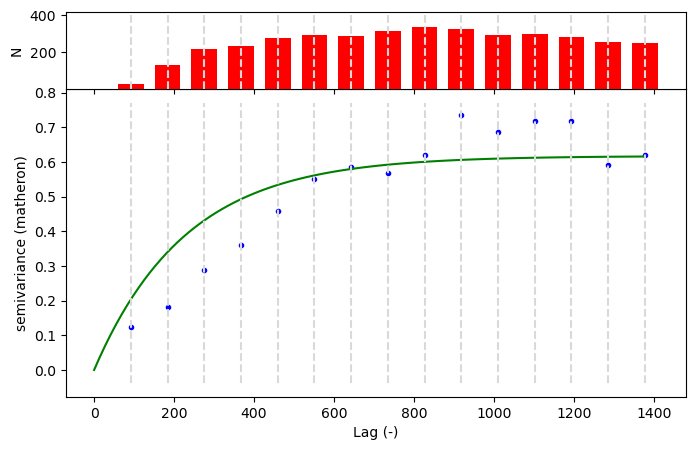

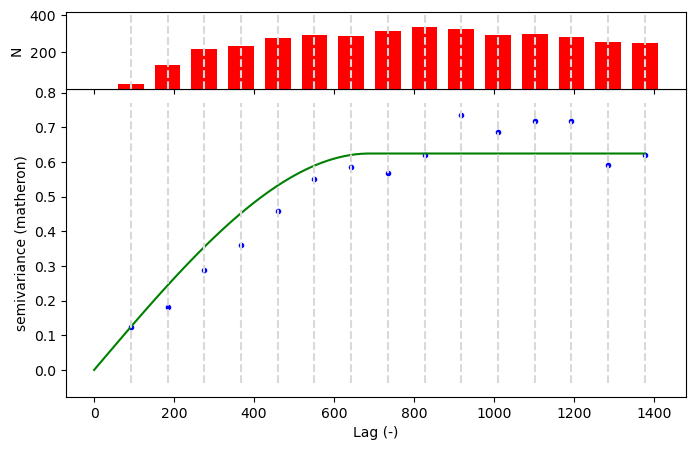

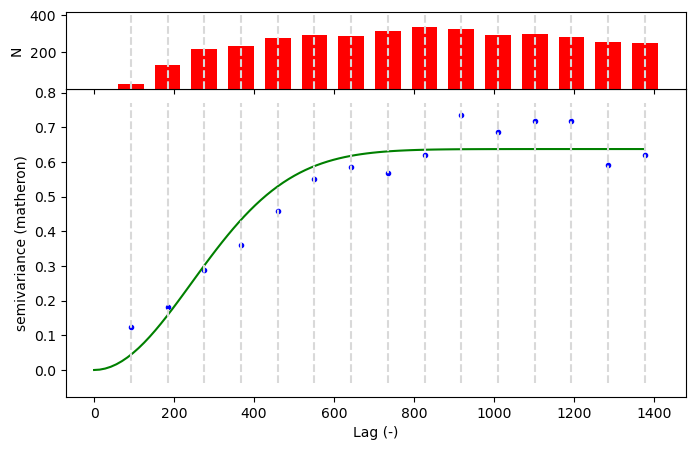

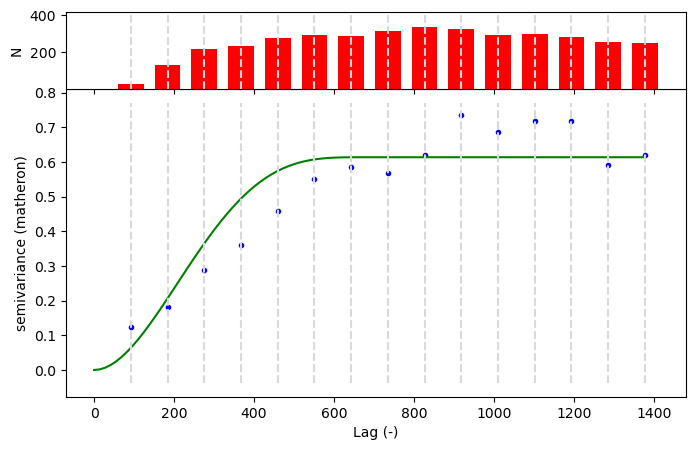

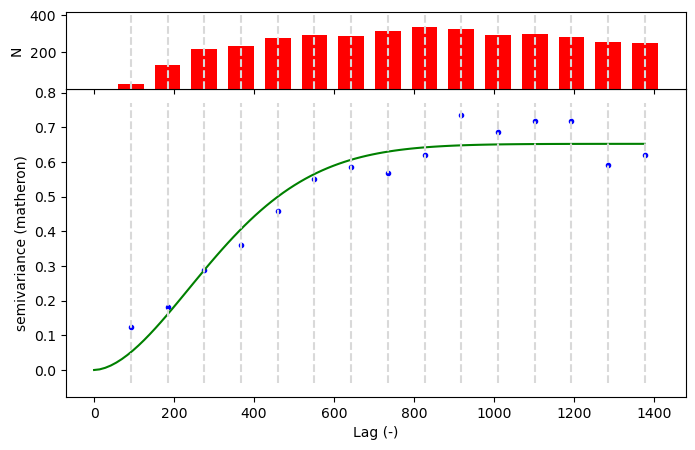

In [22]:
cv_results_df_list = []
models = ['exponential', 'spherical', 'gaussian', 'cubic', 'stable']
min_range = range(1,6)
max_range = range(6,15)
parameters = [
    {'min_points': min_range},
    {'max_points' : max_range}
]

for model in range(len(models)):
    V = skg.Variogram(X_train_meuse, y_train_meuse.flatten(), model = models[model],
                      fit_method = 'ml', maxlag='median', n_lags=15, normalize=False)
    fig = V.plot(show=False)
    print('Sample variance: %.2f   Variogram sill: %.2f' % (y_train_meuse.flatten().var(), V.describe()['sill']))
    ok = skg.OrdinaryKriging(V, mode='exact')
    pred_values = ok.transform(X_train_meuse[0],X_train_meuse[1])
    
    s2 = ok.sigma


Sample variance: 0.53   Variogram sill: 0.62
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


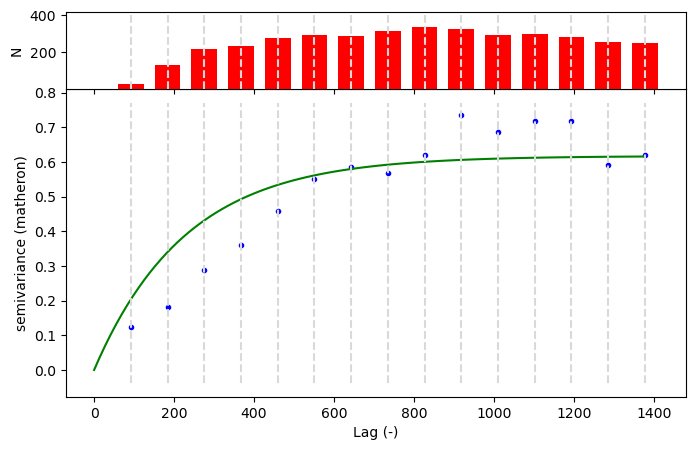

In [24]:
V = skg.Variogram(X_train_meuse, y_train_meuse.flatten(), model = 'exponential',
                  fit_method = 'ml', maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)
print('Sample variance: %.2f   Variogram sill: %.2f' % (y_train_meuse.flatten().var(), V.describe()['sill']))
ok = skg.OrdinaryKriging(V, mode='exact')

# build the target grid
x = X_train_meuse[0]
y = X_train_meuse[1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_train_meuse, field)
rmse = np.sqrt(mean_squared_error(y_train_meuse, field))
#print("MAPE:", round(test_score,3))
print("MAE:", round(mae,3))
print("RMSE:", round(rmse,3))

ValueError: Found input variables with inconsistent numbers of samples: [124, 100]

Sample variance: 0.53   Variogram sill: 0.62


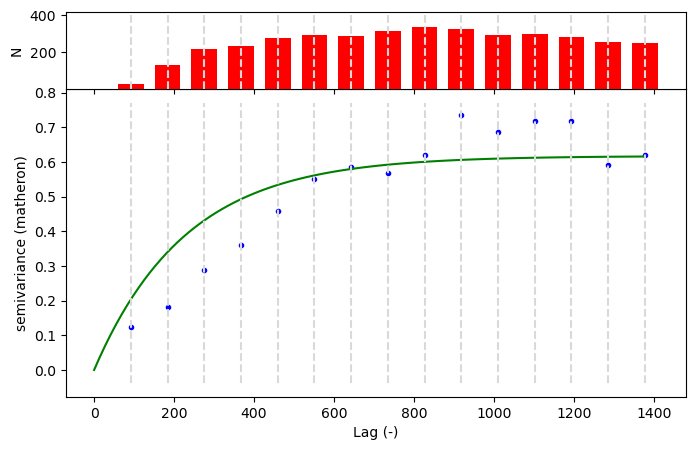

In [23]:
V = skg.Variogram(X_train_meuse, y_train_meuse.flatten(), model = 'exponential',
                  fit_method = 'ml', maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)
print('Sample variance: %.2f   Variogram sill: %.2f' % (y_train_meuse.flatten().var(), V.describe()['sill']))
ok = skg.OrdinaryKriging(V, mode='exact')
pred_values = ok.transform(X_train_meuse[0],X_train_meuse[1])
s2 = ok.sigma

In [20]:
X_train_meuse

array([[180555, 332707],
       [179301, 330179],
       [179462, 330766],
       [180704, 332664],
       [180237, 332351],
       [179782, 330540],
       [179547, 330245],
       [180973, 332687],
       [180114, 330803],
       [179076, 331005],
       [180292, 332157],
       [180625, 332847],
       [179526, 331936],
       [181133, 332570],
       [181118, 333214],
       [179604, 332059],
       [181165, 333537],
       [180107, 332101],
       [180410, 332031],
       [179618, 330458],
       [181191, 333115],
       [179470, 331125],
       [180862, 333116],
       [179030, 330082],
       [179550, 329940],
       [179489, 331633],
       [179110, 330758],
       [179337, 329870],
       [179414, 331494],
       [179085, 330433],
       [180201, 331160],
       [179991, 331069],
       [180265, 332297],
       [179717, 331441],
       [180135, 331552],
       [178701, 330557],
       [179334, 331366],
       [179293, 330797],
       [180173, 331923],
       [179140, 330955],


In [7]:
pprint(V.describe())

{'dist_func': 'euclidean',
 'effective_range': 948.7288337231124,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 1302287.83139491,
 'normalized_nugget': 0,
 'normalized_sill': 284534179.8289792,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'ml',
            'fit_sigma': None,
            'maxlag': 1372.6660191029719,
            'model': 'spherical',
            'n_lags': 15,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 16066.250773906831}


In [8]:
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   948.73
Sill:              16066.25
Nugget:            0.00
        


In [9]:
ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

In [10]:
# build the target grid
x = coords[:,0]
y = coords[:,1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

In [11]:
print((xx.max() - xx.min()) / 100)
print((yy.max() - yy.min()) / 100)

27.85
38.97


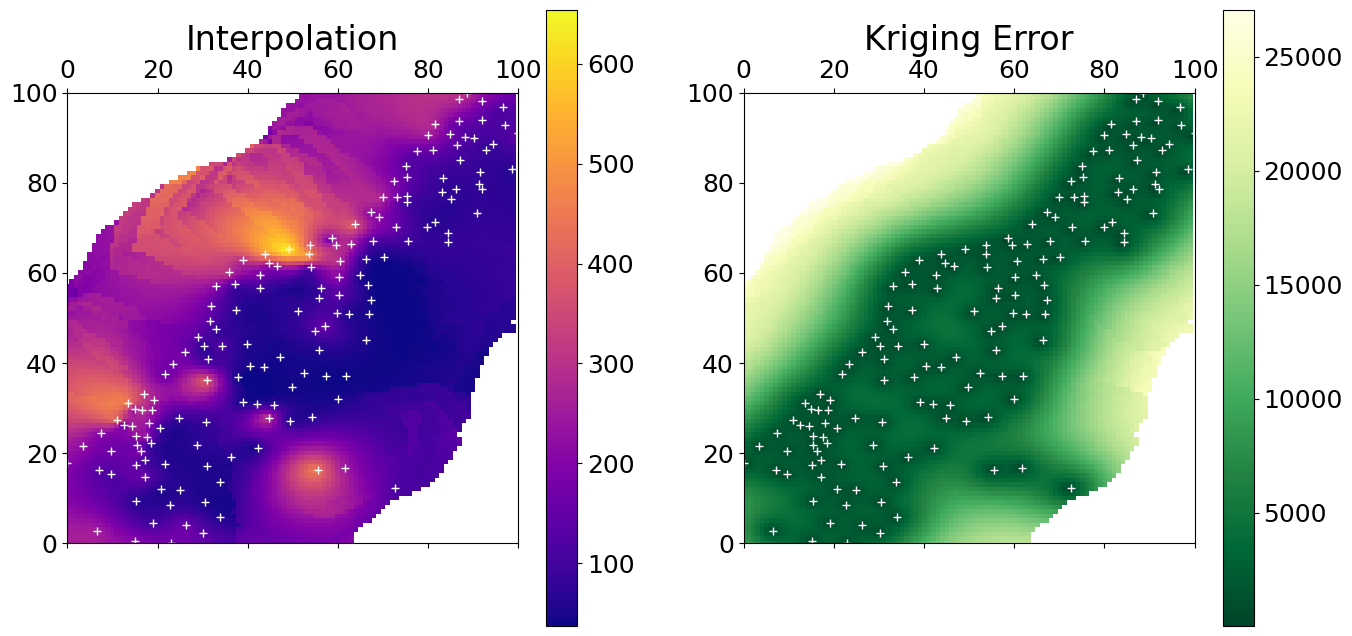

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=vals.min(), vmax=vals.max())
axes[0].set_title('Interpolation')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

In [ ]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

#For each possible theoratical model, conduct K-Fold CV
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    
    V_train = skg.Variogram(X_train_meuse, y_train_meuse,maxlag='median', normalize=False, fit_method = 'ml')
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        # Fit Ordinary Kriging model
        OK = skg.OrdinaryKriging(V_train, min_points=2, max_points=15, mode='exact')

        # Predict at test locations
        z_pred_train = OK.transform(test_data['X'], test_data['Y'])
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[model] = {
        "CV Score MAE" : mean_validation_score_mae,
        "CV Score RMSE" : mean_validation_score_rmse,
        "CV Score MAPE" : mean_validation_score_mape
    }

# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric
# Initialize a dictionary to track the smallest scores and corresponding models
smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "model": None},
    "CV Score RMSE": {"value": float('inf'), "model": None},
    "CV Score MAPE": {"value": float('inf'), "model": None}
}

# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type in scores:
        if scores[score_type] < smallest_scores[score_type]["value"]:
            smallest_scores[score_type]["value"] = scores[score_type]
            smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")